In [8]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mySkewt
from cloud2d_utils import plotXZ, printXZ

_nz     = 25
_nx     = 50
_width  = 10000.
_height = 5000.

# parameters for the initial forcing
_fmag   = -10.
_xcenter = 5000.
_zcenter = 2000.
_radius  = 2000.

# Set up some parameters
rk3       = [0.33333333, 0.5, 1.0]
dt        = 1.0
nsmall    = 6
dts       = dt / nsmall
cssq      = 300.**2
nprint    = 10
nplot     = 50
integrate = 300.
nstep     = np.int(integrate/dt)
grav      = 9.806
Cp        = 1004.
Rgas      = 287.04
C_radius  = 5000.
entrainR  = 0.1
cloud_time = np.zeros((nstep,))

th_clevels = -15. + np.arange(0, 30, 0.5)

#-----------------------------------------------------------------------------
# subroutines for initialization 
#
def init_theta(tbase, gx, gz): 
    x_diff = (gx - _xcenter)**2
    z_diff = (gz - _zcenter)**2
    gridx, gridz = np.meshgrid(x_diff, z_diff)
    dis = np.sqrt(gridx + gridz)

    r = np.where(dis < _radius, dis, _radius ) / _radius
        
    return tbase + _fmag * 0.5 * (np.cos(np.pi*r) + 1.0)

#-----------------------------------------------------------------------------
# subroutines for initialization 
#
def xgrid(nx, width = _width, stag=False): 
    dx = width / np.float(nx)
    if stag:
        dx = width / np.float(nx)
        return dx, np.arange(nx+1)*dx
    else:
        return dx, (np.arange(nx)+0.5)*dx

#-----------------------------------------------------------------------------
# subroutines for initialization 
#
def zgrid(nz, height = _height, stag=False): 
    dz = height / np.float(nz)
    if stag:
        dz = height / np.float(nz)
        return dz, np.arange(nz+1)*dz
    else:
        return dz, (np.arange(nz)+0.5)*dz

#-----------------------------------------------------------------------------
#
def sounding(gz, qv_sfc = 14., type = 'wk_sounding'):
    
    if type == 'wk_sounding':
        
        #define parameters
        theta_sfc  = 300.
        z_trop     = 12000.
        theta_trop = 343.
        temp_trop  = 213.

        # compute theta profile
        theta = 0.0*gz
        t1    = theta_sfc + (theta_trop - theta_sfc)*((gz/z_trop)**1.25)
        t2    = theta_trop * np.exp(grav * (gz - z_trop) / (Cp * temp_trop))   
        theta = np.where(gz <= z_trop, t1, t2)

        # compute rh profile
        rh    = np.where(gz <= z_trop, 1.0 - 0.75*((gz/z_trop)**1.25), 0.25)
    else:
        theta_sfc  = 300.
        theta      = 0.0*gz
        theta[:]   = theta_sfc
        rh         = 0.0*gz
        rh[:]      = 0.0
    
    # integrate hydrostatic eq
    pi    = 0.0*gz
    p     = 0.0*gz
    pi[0] = 1.0 - 0.5*dz*grav/(Cp*theta_sfc)
    
    for k in np.arange(1,gz.shape[0]):
        pi[k] = pi[k-1] - 2.0*dz*grav/(Cp*(theta[k-1]+theta[k]))
    
    # compute pressure (Pa) profile
    p = 1.0e5 * pi**(3.5088)
    t = pi*theta - 273.16
      
    if type == 'wk_sounding':
        
        # compute qv profile
        qvs = (380./p) * np.exp(17.27*((pi*theta - 273.16)/(pi*theta-36.)))
        qv  = qvs*rh
        qv  = np.where( qv > qv_sfc/1000., qv_sfc/1000., qv)

        # recompute RH so that it reflects the new qv_sfc limit - needed to dewpoint computation.
        rh  = qv/qvs

        ess = 6.112 * np.exp(17.67 * t / (t + 243.5))
        val = np.log(rh * ess/6.112)
        td  = 243.5 * val / (17.67 - val)
        
    else:
        qv = 0.0*gz
        td = 0.0*gz
        td[:] = 273.16 - 40.
    
    den = p / (t+273.16 * Rgas)
    
    return pi, theta, qv, p, t, td, den
    

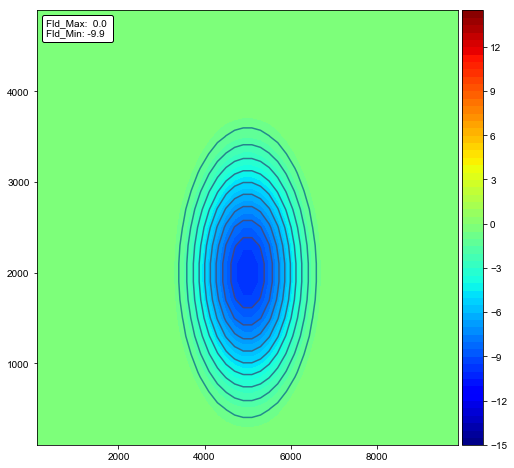

In [9]:
# Initialization Cell

# Create vertical grid
dz, gzc        = zgrid(_nz)
dz, gze        = zgrid(_nz, stag=True)
dx, gxc        = xgrid(_nx)
dx, gxe        = xgrid(_nx, stag=True)

cloud_time = np.zeros((nstep,))

# init soundng

pi00, th00, qv00, p00, t00, td00, r00 = sounding(gzc, type='adiabatic')

# plot skewt
#mySkewt.SkewPlot(p00/100., t00, td00)

# Initialize 2D variables

# W 
w0  = np.zeros((_nz+1, _nx))
w1  = np.zeros((_nz+1, _nx))
fw  = np.zeros((_nz+1, _nx))

# U 
u0  = np.zeros((_nz, _nx+1))
u1  = np.zeros((_nz, _nx+1))
fu  = np.zeros((_nz, _nx+1))

# perturbation pressure 
p0  = np.zeros((_nz, _nx)) 
p1  = np.zeros((_nz, _nx))

# theta 
t0  = np.ones((_nz, _nx)) * th00.reshape(_nz,1)
t1  = np.ones((_nz, _nx)) * th00.reshape(_nz,1)
ft   = np.zeros((_nz, _nx))

t0 = init_theta(t0, gxc, gzc)
t1 = init_theta(t1, gxc, gzc)

plotXZ(gxc, gzc, t0, th_clevels, basestate=th00, showplot=True, saveplot="figure1")


In [10]:
# Routines for solving the System

#-----------------------------------------------------------------------------
# buoyancy forcing for w-equation
#
def buoyancy(t, t0):

    nz = t.shape[0]

#     return grav*((t/t0. - 1.0) + 0.61*(qv - qv0) - qc - qr )
    return grav*(t/t0.reshape(nz,1) - 1.0)


#-----------------------------------------------------------------------------
# compute small step time stepping
#
def smallstep(u, fu, w, fw, p, den1d, dx, dz, dts, nsm):
        
    nz = u.shape[0]
    nx = w.shape[1]
    
    wd    = 0.0*w  # make same size as w 
    wnew  = 0.0*w
    fwd   = 0.0*fw
    fud   = 0.0*fu
    div   = 0.0*p  # make same size as p
    
    den_w = (0.5*(den1d[:-1] + den1d[1:]))
    
    wd[1:-1,:]  = w[1:-1,:]  * den_w.reshape(nz-1,1)
    fwd[1:-1,:] = fw[1:-1,:] * den_w.reshape(nz-1,1)
    ud          = u  * den1d.reshape(nz,1)
    fud         = fu * den1d.reshape(nz,1)
    pd          = p.copy()

    for n in np.arange(nsm):
        ud[:,1:-1] = ud[:,1:-1] + dts * (fud[:,1:-1] - (pd[:,1:] - pd[:,0:-1]) / dx)
        wd[1:-1,:] = wd[1:-1,:] + dts * (fwd[1:-1,:] - (pd[1:,:] - pd[0:-1,:]) / dz)
            
        div        = ((ud[:,1:] - ud[:,:-1]) / dx) + ((wd[1:,:] - wd[:-1,:]) / dz)
        pd         = pd - cssq * dts * div        
        
    unew         = ud / den1d.reshape(nz,1)
    wnew[1:-1,:] = wd[1:-1,:] / den_w.reshape(nz-1,1)
    
    return unew, wnew, pd
 
#-----------------------------------------------------------------------------
# compute vertical advection of w
#
def w_advect(w, dz):
    
    w_avg = 0.0*w  # make it same size as w to simplify code indices
    dwdt  = 0.0*w  # make it same size as w to simplify code indices
    
    # create average velocity
    w_avg[1:-1] = 0.25*(w[0:-2] + 2.0*w[1:-1] + w[2:])
    
    dwdt[2:-3] = -(w_avg[2:-3]/(12.*dz)) * (-w[4:-1] + 8.0*w[3:-2]               - 8.0*w[1:-4] + w[0:-5]) \
             - abs(w_avg[2:-3]/(12.*dz)) * ( w[4:-1] - 4.0*w[3:-2] + 6.0*w[2:-3] - 4.0*w[1:-4] + w[0:-5])

#     dwdt[2:-3]  = - (w_avg[2:-3]/(2.*dz)) * (w[3:-2] - w[1:-4])

    dwdt[1]     = - w_avg[ 1] * 0.5 * (w[2] - w[1] ) / dz
    dwdt[-2]    = - w_avg[-1] * 0.5 * (w[-1]- w[-2]) / dz
    
    return dwdt

#-----------------------------------------------------------------------------
# compute vertical advection of scalars
#
def s_advect(u, w, s, dx, dz):

    u_avg = 0.0*s # make it same size as scalar array to simplify code indices
    udsdx = 0.0*s # make it same size as scalar array to simplify code indices
    
    # create average velocity
    u_avg[:,0:-1] = 0.5*(u[:,0:-2] + u[:,1:-1])
     
    udsdx[:,2:-3] = -(u_avg[:,2:-3]/(12.*dx))*(-s[:,4:-1] + 8.0*s[:,3:-2]                 - 8.0*s[:,1:-4] + s[:,0:-5]) \
                - abs(u_avg[:,2:-3]/(12.*dx))*( s[:,4:-1] - 4.0*s[:,3:-2] + 6.0*s[:,2:-3] - 4.0*s[:,1:-4] + s[:,0:-5])

    # assume zero-gradient BC's
    udsdx[:, 0] = - u_avg[:, 0] * 0.5 * (s[:, 1] - s[:, 0]) / dx
    udsdx[:, 1] = - u_avg[:, 1] * 0.5 * (s[:, 2] - s[:, 0]) / dx
    udsdx[:,-2] = - u_avg[:,-2] * 0.5 * (s[:,-1] - s[:,-3]) / dx
    udsdx[:,-1] = - u_avg[:,-1] * 0.5 * (s[:,-1] - s[:,-2]) / dx

    w_avg = 0.0*s  # make it same size as scalar array to simplify code indices
    wdsdz = 0.0*s # make it same size as scalar array to simplify code indices
    
    # create average velocity
    w_avg[0:-1,:] = 0.5*(w[0:-2,:] + w[1:-1,:])
     
    wdsdz[2:-3,:] = -(w_avg[2:-3,:]/(12.*dz))*(-s[4:-1,:] + 8.0*s[3:-2,:]                 - 8.0*s[1:-4,:] + s[0:-5,:]) \
                - abs(w_avg[2:-3,:]/(12.*dz))*( s[4:-1,:] - 4.0*s[3:-2,:] + 6.0*s[2:-3,:] - 4.0*s[1:-4,:] + s[0:-5,:])

    # assume zero-gradient BC's
    wdsdz[ 0,:] = - w_avg[ 0,:] * 0.5 * (s[ 1,:] - s[ 0,:]) / dz
    wdsdz[ 1,:] = - w_avg[ 1,:] * 0.5 * (s[ 2,:] - s[ 0,:]) / dz
    wdsdz[-2,:] = - w_avg[-2,:] * 0.5 * (s[-1,:] - s[-3,:]) / dz
    wdsdz[-1,:] = - w_avg[-1,:] * 0.5 * (s[-1,:] - s[-2,:]) / dz
    
    return udsdx + wdsdz


 ------------  T = 10.000000 ---------------

 Umax:      0.6062    Umin:     -0.6062 
 Wmax:      0.3020    Wmin:     -1.5750 
 Pmax:    291.3564    Pmin:   -159.8853 
 Tmax:      0.0006    Tmin:     -9.8869 

 -------------------- ---------------


 ------------  T = 20.000000 ---------------

 Umax:      1.2371    Umin:     -1.2371 
 Wmax:      1.2684    Wmin:     -2.6379 
 Pmax:    219.1761    Pmin:   -138.5789 
 Tmax:      0.0017    Tmin:     -9.9068 

 -------------------- ---------------


 ------------  T = 30.000000 ---------------

 Umax:      1.8150    Umin:     -1.8150 
 Wmax:      1.8939    Wmin:     -4.1361 
 Pmax:    108.1207    Pmin:    -82.3075 
 Tmax:      0.0033    Tmin:     -9.9283 

 -------------------- ---------------


 ------------  T = 40.000000 ---------------

 Umax:      2.5839    Umin:     -2.5839 
 Wmax:      2.2089    Wmin:     -5.7321 
 Pmax:    228.1248    Pmin:   -148.3978 
 Tmax:      0.0058    Tmin:     -9.9351 

 -------------------- -------------

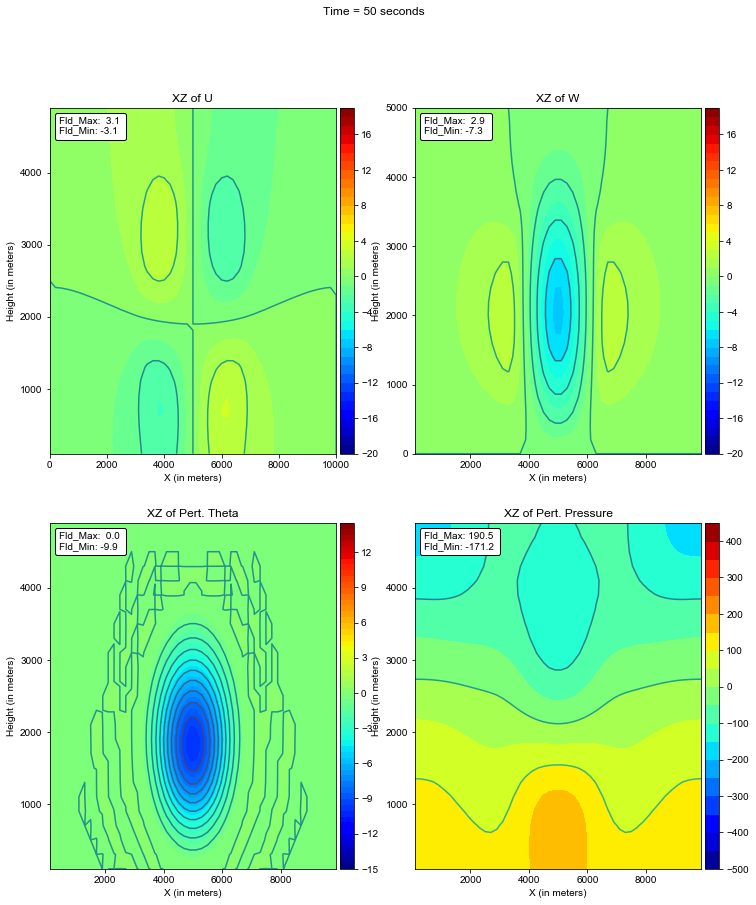


 ------------  T = 60.000000 ---------------

 Umax:      3.8532    Umin:     -3.8532 
 Wmax:      3.7435    Wmin:     -8.3358 
 Pmax:    210.8109    Pmin:   -141.0386 
 Tmax:      0.0150    Tmin:     -9.9196 

 -------------------- ---------------


 ------------  T = 70.000000 ---------------

 Umax:      4.6065    Umin:     -4.6065 
 Wmax:      4.0201    Wmin:     -9.9805 
 Pmax:    101.0755    Pmin:    -96.5680 
 Tmax:      0.0173    Tmin:     -9.9234 

 -------------------- ---------------


 ------------  T = 80.000000 ---------------

 Umax:      5.1300    Umin:     -5.1300 
 Wmax:      4.5345    Wmin:    -11.5870 
 Pmax:    303.2834    Pmin:   -160.3252 
 Tmax:      0.0209    Tmin:     -9.9101 

 -------------------- ---------------


 ------------  T = 90.000000 ---------------

 Umax:      6.0473    Umin:     -6.0473 
 Wmax:      5.4855    Wmin:    -12.2699 
 Pmax:    214.4312    Pmin:   -107.5759 
 Tmax:      0.0229    Tmin:     -9.9158 

 -------------------- -------------

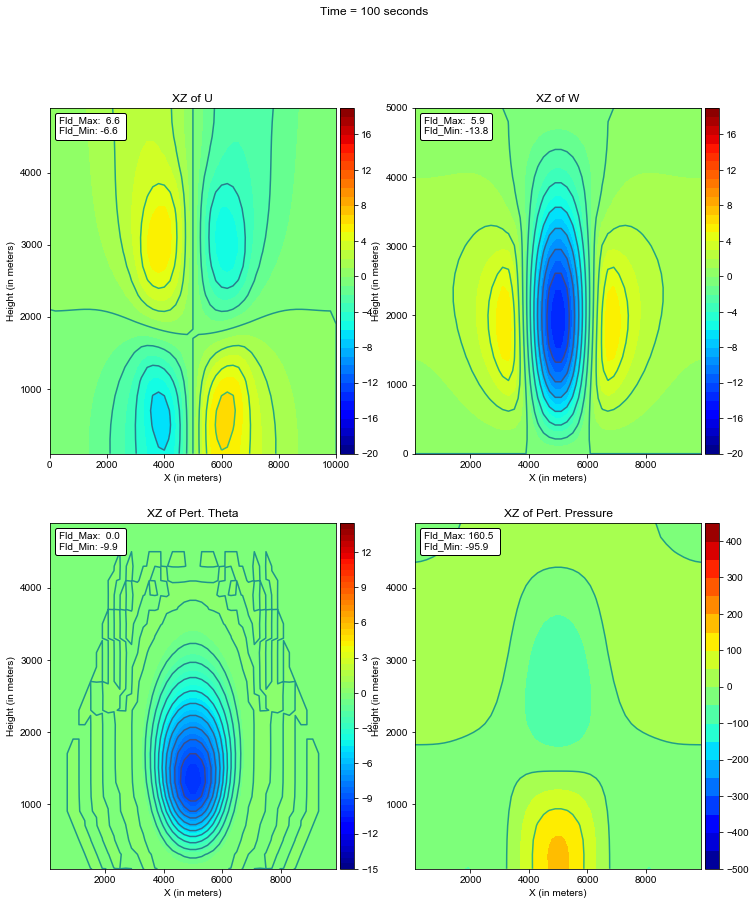


 ------------  T = 110.000000 ---------------

 Umax:      7.4157    Umin:     -7.4157 
 Wmax:      6.2659    Wmin:    -15.1119 
 Pmax:    307.3161    Pmin:   -133.8991 
 Tmax:      0.0224    Tmin:     -9.8662 

 -------------------- ---------------


 ------------  T = 120.000000 ---------------

 Umax:      8.2474    Umin:     -8.2474 
 Wmax:      7.0023    Wmin:    -15.9175 
 Pmax:    174.3454    Pmin:   -112.5195 
 Tmax:      0.0224    Tmin:     -9.9492 

 -------------------- ---------------


 ------------  T = 130.000000 ---------------

 Umax:      9.1649    Umin:     -9.1649 
 Wmax:      7.6774    Wmin:    -16.6451 
 Pmax:    275.5668    Pmin:   -101.9112 
 Tmax:      0.0226    Tmin:     -9.9017 

 -------------------- ---------------


 ------------  T = 140.000000 ---------------

 Umax:     10.0045    Umin:    -10.0045 
 Wmax:      7.8022    Wmin:    -17.8410 
 Pmax:    189.2563    Pmin:   -102.4233 
 Tmax:      0.0244    Tmin:     -9.9263 

 -------------------- ---------

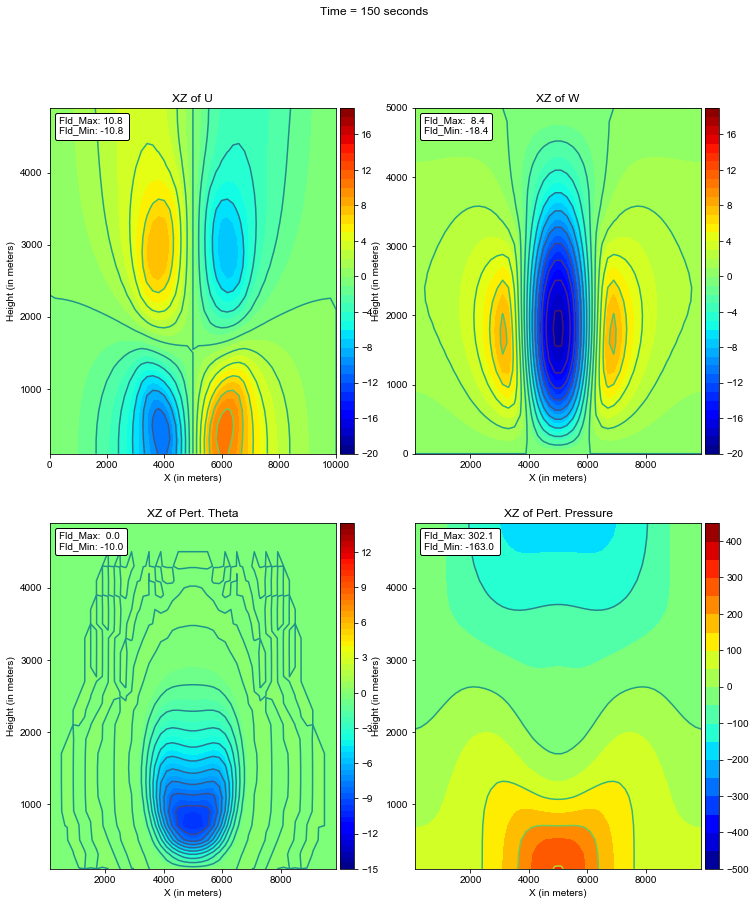


 ------------  T = 160.000000 ---------------

 Umax:     11.8329    Umin:    -11.8329 
 Wmax:      9.1531    Wmin:    -18.3933 
 Pmax:    311.7525    Pmin:   -112.3062 
 Tmax:      0.0280    Tmin:     -9.8771 

 -------------------- ---------------


 ------------  T = 170.000000 ---------------

 Umax:     12.5192    Umin:    -12.5192 
 Wmax:      9.2201    Wmin:    -19.4284 
 Pmax:    190.5579    Pmin:    -98.6506 
 Tmax:      0.0332    Tmin:    -10.0810 

 -------------------- ---------------


 ------------  T = 180.000000 ---------------

 Umax:     13.6643    Umin:    -13.6643 
 Wmax:      9.6763    Wmin:    -19.3912 
 Pmax:    322.8290    Pmin:   -143.6560 
 Tmax:      0.0370    Tmin:    -10.1628 

 -------------------- ---------------


 ------------  T = 190.000000 ---------------

 Umax:     14.5990    Umin:    -14.5990 
 Wmax:     10.1503    Wmin:    -19.3186 
 Pmax:    254.8333    Pmin:   -138.4287 
 Tmax:      0.0390    Tmin:     -9.8784 

 -------------------- ---------

In [ ]:
# Integrate the cloud model with constant buoyancy forcing for a few time step with only pressure gradient 
# and buoyancy forcing

nlen = 1
rk_steps = 3

cloud_time = np.zeros((nstep/nlen,))

# Need to re-init the variables because of IPython

u1[...] = 0.0
w1[...] = 0.0
p1[...] = 0.0
t1 = np.ones((_nz, _nx)) * th00.reshape(_nz,1)
t1 = init_theta(t1, gxc, gzc)


# Main time loop for assignment #1
for n in np.arange(1,nstep/nlen):
    
    # first copy "n" time level to temporary arrays
    u0[...] = u1[...]
    w0[...] = w1[...]
    p0[...] = p1[...]
    t0[...] = t1[...]
    
    # RK steps
    for m in np.arange(rk_steps):
        
        dtl  = rk3[m]*dt
        time = n*dt + m*dtl 
        ns   = nsmall / (rk_steps-m)
        
        fu[...] = 0.0
        fw[...] = 0.0
        ft[...] = 0.0

        # Compute buoyancy
        b = buoyancy(t1, th00)

        fw[1:-1,:] = (b[:-1,:]+b[1:,:])/2.0

        ft = s_advect(u1, w1, t1, dx, dz)
        
        # Make RK step 
  
        # Reset small step variables to start at t = "n"
        p1 = p0.copy()
        u1 = u0.copy()
        w1 = w0.copy()
        t1 = t0 + dtl * ft

        # Call small time step
        u2, w2, p2 = smallstep(u1, fu, w1, fw, p1, r00, dx, dz, dts, ns)

        # Copy variables from small step into t = "1" variables

        p1 = p2.copy()
        u1 = u2.copy()
        w1 = w2.copy()
        
    cloud_time[n] = (n+1)*dt
  
    # Print out max/mins
    if ((n+1) % nprint) == 0:
        printXZ(u1, w1, p1, t1, cloud_time[n], basestate=th00 )

        
#     # Plotting stuff
    if ((n+1) % nplot) == 0:

        w_clevels  = np.arange(-20, 20, 1.0)
        th_clevels = -15. + np.arange(0, 30, 0.5)
        p_clevels  = np.arange(-500, 500, 50.)

        plt.figure(figsize = (12,14))

        ax = plt.subplot(221)

        plotXZ(gxe, gzc, u1, w_clevels, ax=ax,
                         main='XZ of U',
                         xlabel='X (in meters)',
                         ylabel='Height (in meters)')

        ax = plt.subplot(222)

        plotXZ(gxc, gze, w1, w_clevels, ax=ax, \
                         main='XZ of W',
                         xlabel='X (in meters)',
                         ylabel='Height (in meters)')

        ax = plt.subplot(223)

        plotXZ(gxc, gzc, t1, th_clevels, basestate=th00, ax=ax,
                         main='XZ of Pert. Theta',
                         xlabel='X (in meters)',
                         ylabel='Height (in meters)')

        ax = plt.subplot(224)

        plotXZ(gxc, gzc, p1, p_clevels, ax=ax,
                         main='XZ of Pert. Pressure',
                         time = cloud_time[n],
                         xlabel='X (in meters)',
                         ylabel='Height (in meters)')
        plt.show()
